# Принятие решений в бизнесе

## Описание проекта

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.<br>
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.


## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt
import numpy as np
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150
import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')

except FileNotFoundError:
    hypothesis = pd.read_csv('hypothesis.csv')
    orders = pd.read_csv('orders.csv')
    visitors = pd.read_csv('visitors.csv')

In [3]:
data = [hypothesis, orders, visitors]
for data in data:
    data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   

In [4]:
name_hypothesis = ['hypothesis', 'reach', 'impact', 'confidence', 'efforts']
name_orders = ['orderId', 'userId', 'date','revenue', 'group']
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv', names=name_hypothesis, header=0)
    orders = pd.read_csv('/datasets/orders.csv', names=name_orders, header=0)
    visitors = pd.read_csv('/datasets/visitors.csv')

except FileNotFoundError:
    hypothesis = pd.read_csv('hypothesis.csv', names=name_hypothesis, header=0)
    orders = pd.read_csv('orders.csv', names=name_orders, header=0)
    visitors = pd.read_csv('visitors.csv')

In [5]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [6]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [7]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [8]:
orders.head(5)

,orderId,userId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [9]:
visitors.sample(5)

,date,group,visitors
40,2019-08-10,B,369
61,2019-08-31,B,718
16,2019-08-17,A,412
1,2019-08-02,A,619
38,2019-08-08,B,654


In [10]:
duplicated_users = orders.groupby('userId').agg({'group': ['nunique', 'unique']})
duplicated_users.columns = ['groups', 'group_names']
duplicated_users = duplicated_users.query('groups > 1')
duplicated_users.head(5)

,groups,group_names
userId,,
8300375,2,"[B, A]"
199603092,2,"[A, B]"
232979603,2,"[B, A]"
237748145,2,"[B, A]"
276558944,2,"[B, A]"


In [11]:
len(duplicated_users)

58

Есть 58 пользователей, которые попали в две группы одновременно, но чистить пользователей с несколькими группами в этом проекте не обязательно, потому как согласно данным из таблицы visitors по группам делили не пользователей, а визиты (или сессии, что одно другому не противоречит).

In [12]:
orders.duplicated().sum()

0

In [13]:
visitors.duplicated().sum()

0

## Приоритизация гипотез.

### Расчет приоритизации (метод ICE):

In [14]:
hypothesis['ice'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis['ice_rank'] = hypothesis['ice'].rank(ascending = False).astype('int')
hypothesis = hypothesis.round(2).sort_values(by='ice', ascending=False)
hypothesis

,hypothesis,reach,impact,confidence,efforts,ice,ice_rank
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,1
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,2
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,4
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,5
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,6
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,7
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,9


Топ3 гипотез по методу ICE :
 1. Запустить акцию, дающую скидку на товар в день рождения (reach 1)
 2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (reach 3)
 3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (reach 10)

### Расчет приоритизации (метод RICE):

In [15]:
hypothesis['rice'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis['rice_rank'] = hypothesis['rice'].rank(ascending = False, method = 'first').astype('int')
hypothesis = hypothesis.round(2).sort_values(by='rice', ascending=False)
hypothesis

,hypothesis,reach,impact,confidence,efforts,ice,ice_rank,rice,rice_rank
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,3,112.0,1
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,5,56.0,2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,2,40.0,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,4,40.0,4
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,1,16.2,5
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,8,9.0,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,6,4.0,7
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,7,4.0,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,9,3.0,9


Топ3 гипотез по методу RICE :
 1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (reach 10)
 2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа (reach 8)     
 3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (reach 3)

### Изменения приоритизаций гипотез при применении RICE вместо ICE

In [16]:
h_comparison = hypothesis.copy()
h_comparison['difference'] = h_comparison['ice_rank'] - h_comparison['rice_rank']
h_comparison.sort_values(by = 'difference', ascending = False)

,hypothesis,reach,impact,confidence,efforts,ice,ice_rank,rice,rice_rank,difference
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,5,56.0,2,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,3,112.0,1,2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,8,9.0,6,2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,4,40.0,4,0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,9,3.0,9,0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,2,40.0,3,-1
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,6,4.0,7,-1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,7,4.0,8,-1
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,1,16.2,5,-4


Параметр Reach(скольких пользователей затронет изменение, которое вы хотите внести) сильно влияет на приоритизацию гипотез.<br> 
В таблице четко прослеживается взаимосвязь между охватом(reach) и разницей(difference) в позициях.<br> 
Чем больше охват, тем выше разница приоритетов между RICE и ICE.<br> 
Самая приоритетная гипотеза по методу RICE была только на третьем месте мо методу ICE.<br> 
Отсюда делаю вывод, что метод RICE, наиболее точно решает задачу приоритизации гипотез и потому рекомендую к проверке следующие гипотезы:<br>
- Запустить акцию, дающую скидку на товар в день рождения<br>
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей<br>
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок<br>
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию<br>
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа<br>

## Анализ A/B-теста

### Кумулятивные метрики

#### График кумулятивной выручки по группам

In [17]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

#Получим строки таблицы orders, дата которых меньше или равна дате элемента из datesGroups, а группа теста равна группе из datesGroups:

#orders[np.logical_and(orders['date'] <= datesGroups['date'], orders['group'] == datesGroups['group'])]


# получаем агрегированные кумулятивные по дням данные о заказах
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'orderId' : 'nunique', 'userId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


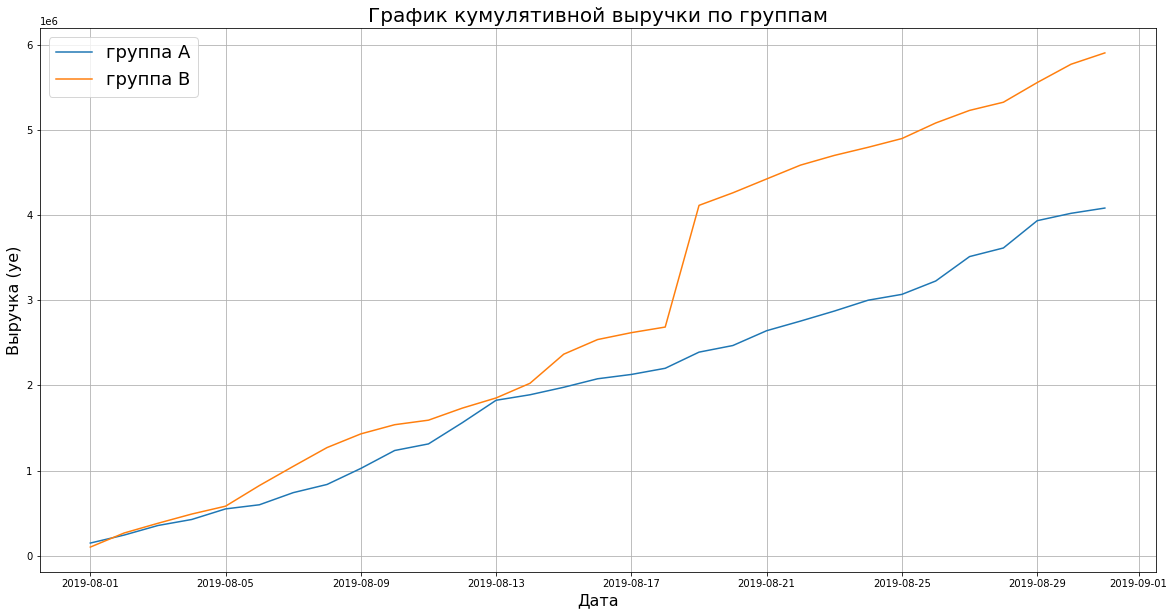

In [18]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(20, 10))
plt.title('График кумулятивной выручки по группам', fontsize=20)
plt.xlabel('Дата', fontsize=16)
plt.ylabel('Выручка (уе)', fontsize=16)
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend(('группа A', 'группа B'),fontsize=18)

plt.grid()
plt.show()

Выручка почти равномерно увеличивается в течение всего теста. 
В середине теста график В резко растёт. Это может сигнализировать о всплеске числа заказов, либо о появлении очень дорогих заказов в выборке.

#### График кумулятивного среднего чека по группам

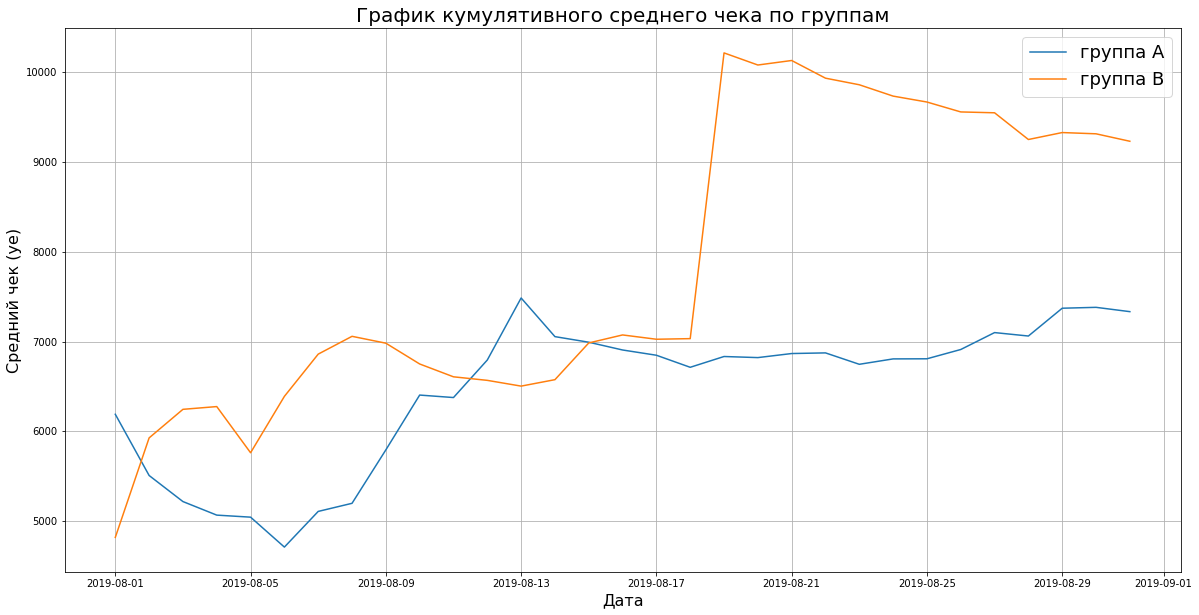

In [19]:
plt.figure(figsize=(20, 10))
plt.title('График кумулятивного среднего чека по группам', fontsize=20)
plt.xlabel('Дата', fontsize=16)
plt.ylabel('Средний чек (уе)', fontsize=16)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend(('группа A', 'группа B'),fontsize=18)
plt.grid()
plt.show()

Средний чек становится равномерным ближе к концу теста: установился для группы A, но есть скачок в группе В. Возможно, в группу B в середине теста попали крупные заказы (резкий всплеск на графике). Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

#### График относительного изменения кумулятивного среднего чека группы B к группе A

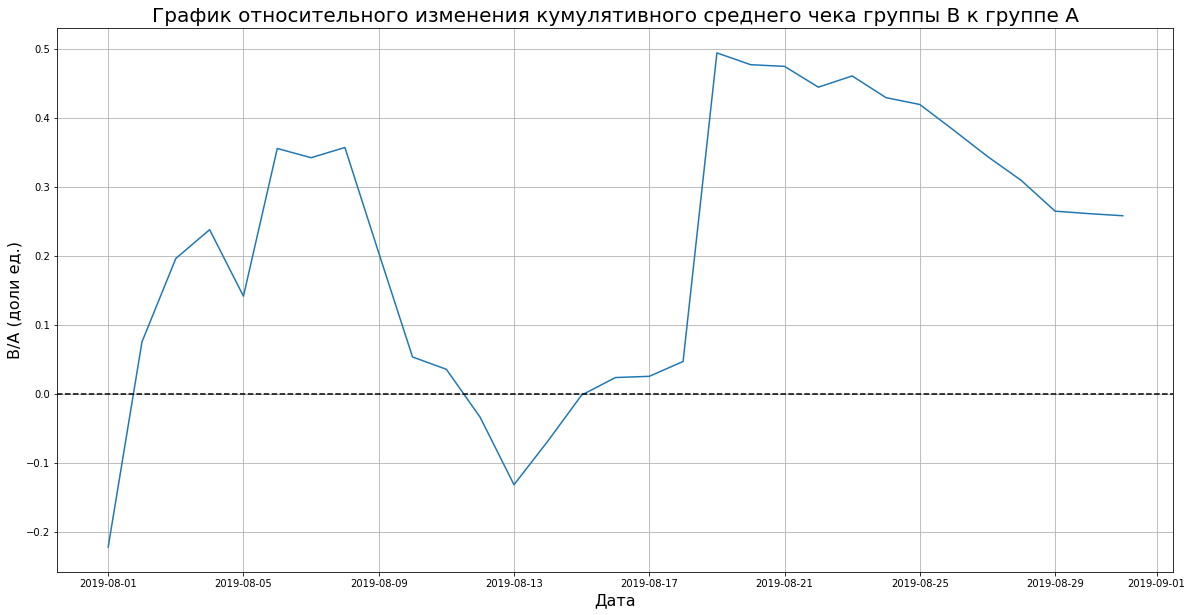

In [20]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(20, 10))
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', fontsize=20)
plt.xlabel('Дата', fontsize=16)
plt.ylabel('В/А (доли ед.)', fontsize=16)
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.grid()
plt.show()



В нескольких точках график различия между сегментами резко «скачет». Где-то уж точно спрятались крупные заказы и выбросы! Найду их позже.

#### График кумулятивной конверсии по группам:

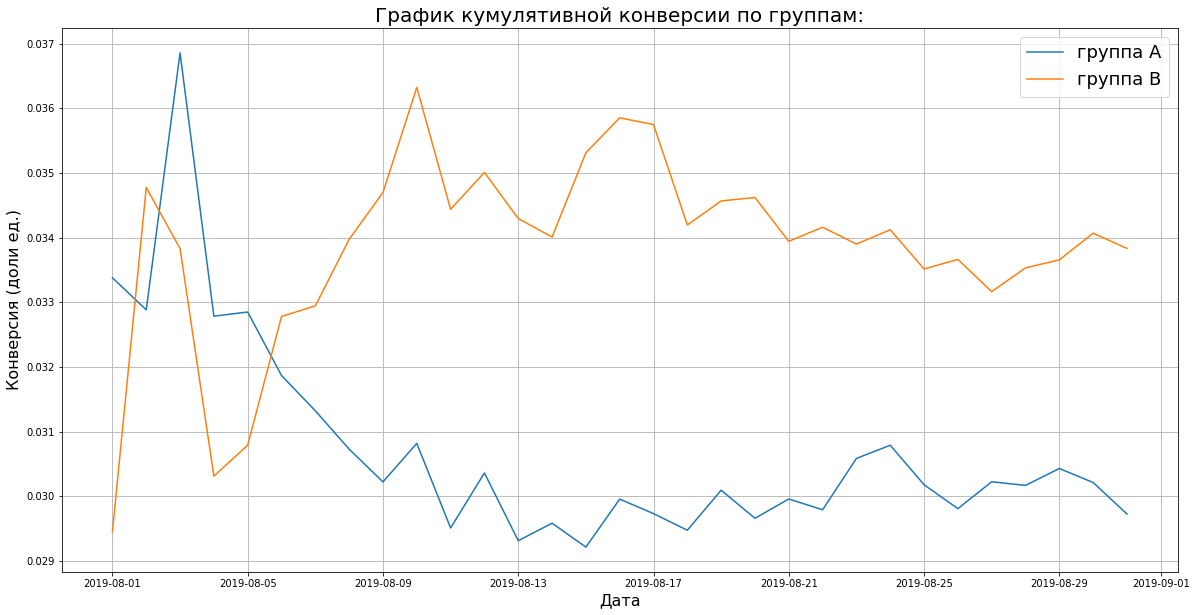

In [21]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(20, 10))
plt.title('График кумулятивной конверсии по группам:', fontsize=20)
plt.xlabel('Дата', fontsize=16)
plt.ylabel('Конверсия (доли ед.)', fontsize=16)
# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.legend(('группа A', 'группа B'),fontsize=18, loc = 1)

plt.grid()
plt.show()

Симметричный график получился! Группы колебались около одного значения, но затем конверсия группы В вырвалась вперёд и зафиксировалась, а конверсия группы А просела и также зафиксировалась.

#### График относительного изменения кумулятивной конверсии группы B к группе A:

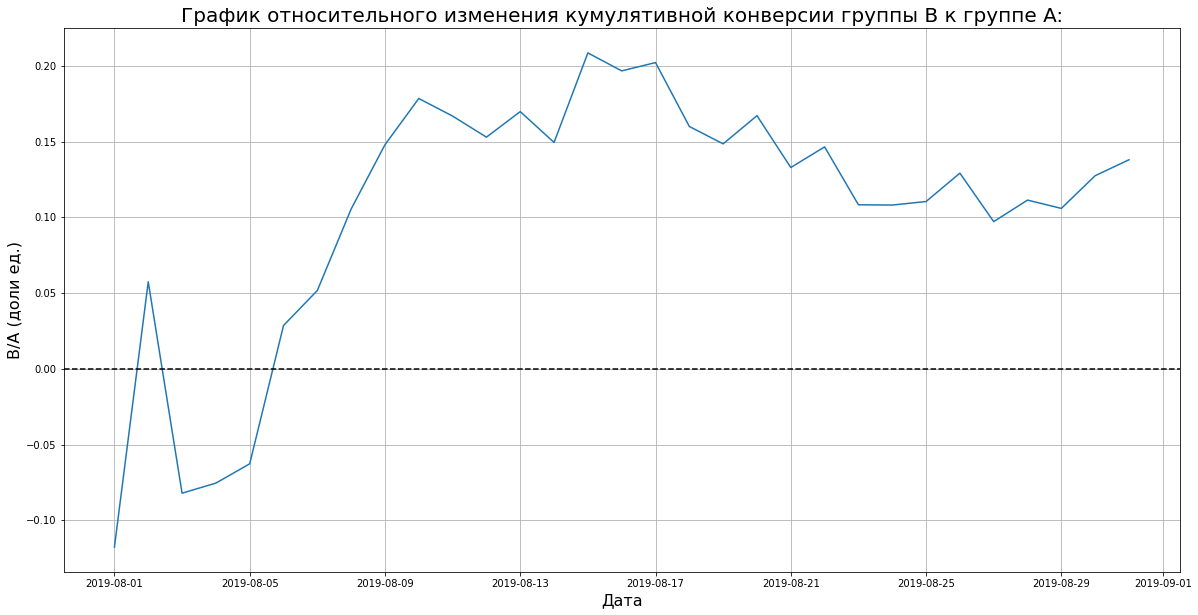

In [22]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(20, 10))
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A:', fontsize=20)
plt.xlabel('Дата', fontsize=16)
plt.ylabel('B/A (доли ед.)', fontsize=16)
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.grid()
plt.show()

В начале теста группа B проигрывала группе A, затем вырвалась вперёд. Потом её конверсия снова падала и держится на одном уровне.
В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя.

### Анализ выбросов и всплесков

#### Точечный график количества заказов по пользователям

In [23]:
ordersByUsers = (
    orders.groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)

ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

          userId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


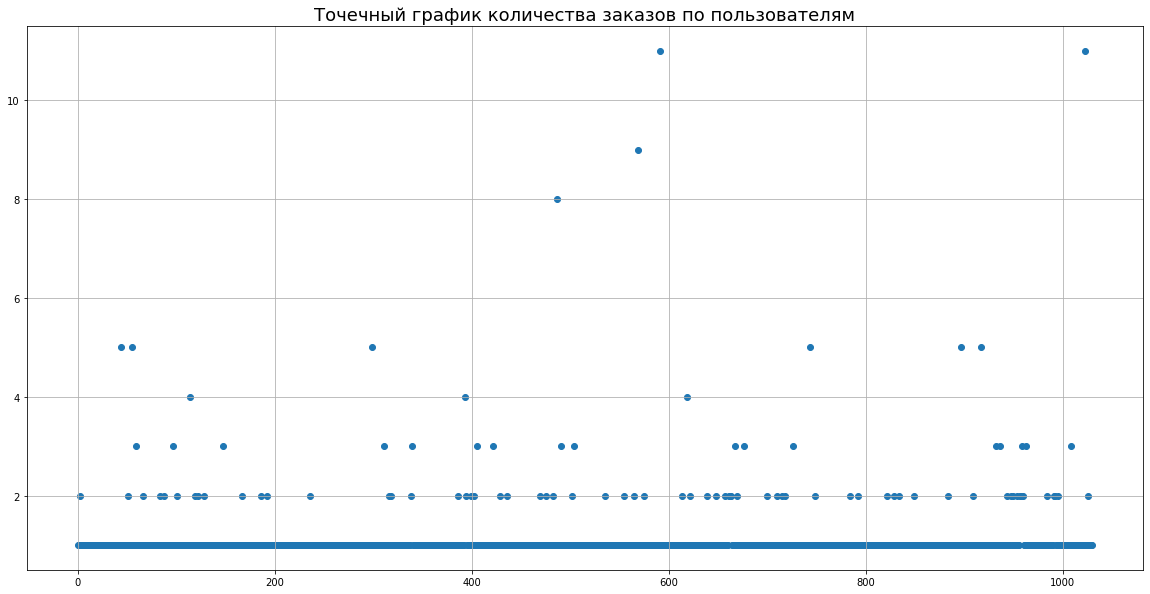

In [24]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(20, 10))
plt.title('Точечный график количества заказов по пользователям', fontsize=18)

plt.scatter(x_values, ordersByUsers['orders'])
plt.grid()
plt.show()

95-й и 99-й перцентили количества заказов на пользователя

In [25]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Не более 5% пользователей оформляли больше чем 2 заказов. И 1% пользователей заказывали более 4 раз.
Разумно выбрать 4 заказа на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней.

#### Точечный график стоимостей заказов

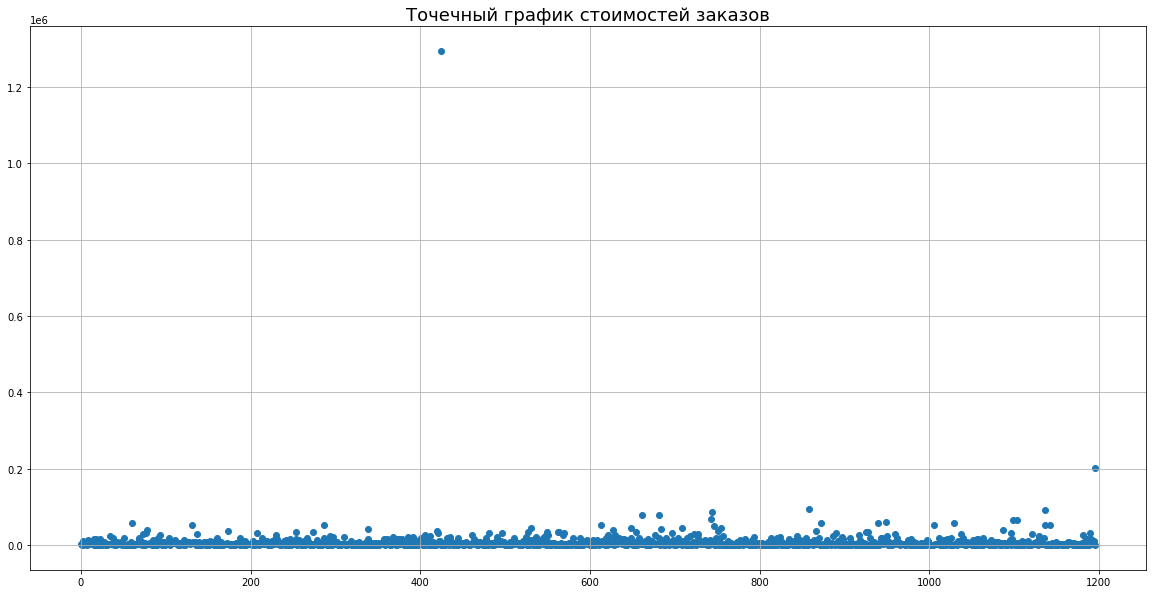

In [26]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(20, 10))
plt.title('Точечный график стоимостей заказов', fontsize=18)
plt.scatter(x_values, orders['revenue'])
plt.grid()
plt.show()

Есть дорогие заказы

95-й и 99-й перцентили стоимости заказов

In [27]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Не более 5% заказов дороже 28000 рублей и не более 1% дороже 58233 рублей.

### Статистическая значимость

#### Подготовка данных

In [28]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Названия столбцов данных:<br>
date — дата;<br>
ordersPerDateA — количество заказов в выбранную дату в группе A;<br>
revenuePerDateA — суммарная выручка в выбранную дату в группе A;<br>
ordersPerDateB — количество заказов в выбранную дату в группе B;<br>
revenuePerDateB — суммарная выручка в выбранную дату в группе B;<br>
ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;<br>
revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;<br>
ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;<br>
revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;<br>
visitorsPerDateA — количество пользователей в выбранную дату в группе A;<br>
visitorsPerDateB — количество пользователей в выбранную дату в группе B;<br>
visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;<br>
visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

Создадим переменные ordersByUsersA и ordersByUsersB со столбцами 'userId', 'orders'. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [29]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

In [30]:
[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]

[0      1
 1      1
 2      1
 3      1
 4      1
       ..
 498    1
 499    7
 500    1
 501    1
 502    1
 Name: orders, Length: 503, dtype: int64,
 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 18228    0
 18229    0
 18230    0
 18231    0
 18232    0
 Name: orders, Length: 18233, dtype: int64]

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [31]:
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')


0        0
1        0
2        0
3        0
4        0
        ..
18228    0
18229    0
18230    0
18231    0
18232    0
Name: orders, Length: 18233, dtype: int64

In [32]:
[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]

[0      1
 1      1
 2      1
 3      1
 4      1
       ..
 498    1
 499    7
 500    1
 501    1
 502    1
 Name: orders, Length: 503, dtype: int64,
 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 18228    0
 18229    0
 18230    0
 18231    0
 18232    0
 Name: orders, Length: 18233, dtype: int64]

In [33]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Найденные выше 95-й и 99-й перцентили средних чеков равны 28000 и 58233 рублям. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказа на пользователя.
Узнаю, сколько всего аномальных пользователей методом shape():

In [34]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['userId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape, 'Всего аномальных пользователей')

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: userId, dtype: int64
(74,) Всего аномальных пользователей


Узнаю, как действия аномальных пользователей повлияли на результаты теста. Подготовлю выборки количества заказов по пользователям по группам теста:

In [35]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

#### Статистическая значимость различий в конверсии между группами по «сырым» данным:

Сформулирую гипотезы:<br>
Нулевая гипотеза: Статистически значимых различий в конверсии между группами А и В по «сырым» данным нет.<br>
Альтернативная гипотеза: Статистически значимые различия в конверсии между группами А и В по «сырым» данным существуют.

In [36]:
alpha = 0.05
results = stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')

print('P-value: {0:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')
    
print('Относительный прирост конверсии группы B по отношению к группе A: {:.3f}'.format(sampleB.mean()/sampleA.mean()-1))

P-value: 0.017
Отвергаем нулевую гипотезу.
Относительный прирост конверсии группы B по отношению к группе A: 0.138


Вывод: По «сырым» данным различия в конверсии групп A и B существуют.

Относительный прирост конверсии группы B по отношению к группе A равен 13.8%.

#### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным.

Сформулирую гипотезы:<br>
Нулевая гипотеза: Статистически значимых различий в среднем чеке между группами А и В по «сырым» данным нет.<br>
Альтернативная гипотеза: Статистически значимые различия в среднем чеке между группами А и В по «сырым» данным существуют.

In [37]:
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative = 'two-sided')
print('P-value: {0:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')
    
print('Относительное изменение в среднем чеке заказа в группе B по отношению к группе A по «сырым» данным: {:.3f}'.format(
orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value: 0.729
Не получилось отвергнуть нулевую гипотезу.
Относительное изменение в среднем чеке заказа в группе B по отношению к группе A по «сырым» данным: 0.259


Не получилось отвергнуть нулевую гипотезу значит, в среднем чеке заказа между группами по «сырым» данным различий, нет.<br> 
Впрочем, средний чек группы B выше среднего чека группы A на 26%.

#### Статистическая значимость различий в конверсии между группами по «очищенным» данным:

Сформулирую гипотезы:<br>
Нулевая гипотеза: Статистически значимых различий в конверсии между группами А и В по «очищенным» данным нет.<br>
Альтернативная гипотеза: Статистически значимые различия в конверсии между группами А и В по «очищенным» данным существуют.

In [38]:
results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')
print('P-value: {0:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')
    
print('Относительный прирост конверсии группы B по отношению к группе A по «очищенным» данным: {:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

P-value: 0.013
Отвергаем нулевую гипотезу.
Относительный прирост конверсии группы B по отношению к группе A по «очищенным» данным: 0.173


Результаты по конверсии практически не изменились. Произошло ли что-нибудь с результатами по среднему чеку?

#### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным:

Сформулирую гипотезы:<br>
Нулевая гипотеза: Статистически значимых различий в среднем чеке между группами А и В по «очищенным» данным нет.<br>
Альтернативная гипотеза: Статистически значимые различия в среднем чеке между группами А и В по «очищенным» данным существуют.

In [39]:
results = stats.mannwhitneyu(orders[np.logical_and(orders['group']=='A', np.logical_not(orders['userId'].isin(abnormalUsers)))]['revenue'],orders[np.logical_and(orders['group']=='B', np.logical_not(orders['userId'].isin(abnormalUsers)))]['revenue'], alternative = 'two-sided')
print('P-value: {0:.3f}'.format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print('Относительное изменение в среднем чеке заказа между группами по «очищенным» данным: {:.3f}'.format(
orders[np.logical_and(orders['group']=='B', np.logical_not(orders['userId'].isin(abnormalUsers)))]['revenue'].mean()\
/orders[np.logical_and(orders['group']=='A', np.logical_not(orders['userId'].isin(abnormalUsers)))]['revenue'].mean()-1))

P-value: 0.738
Не получилось отвергнуть нулевую гипотезу
Относительное изменение в среднем чеке заказа между группами по «очищенным» данным: -0.020


Не получилось отвергнуть нулевую гипотезу. Разница между сегментами сократилась с 26% до 2%.

### Решение по результатам теста:

__По результатам теста получены следующие выводы:__
1. Имеется статистически значимое различие по конверсии между группами как по «сырым», так и по данным после фильтрации аномалий.
2. Отсутствует статистически значимое различие по среднему чеку между группами по «сырым» и по данным после фильтрации аномалий.
3. График различия конверсии между группами демонстрирует, что результаты группы B лучше группы A и нет тенденции к изменению.
4. График выручки накопительным методом показывает преимущество группы В.

__Решение:__

Исходя из результатов теста, конечно можно продолжить тест, пока не стабилизируются графики, не получим больше данных и наблюдений, пока не закончится бюджет, но правильнее будет остановить тест и отдать победу группе В.

## Общий вывод к проекту

__Цель проекта:__<br>
Приоритизировать гипотезы, провести A/B-тест и проанализировать результаты.<br>

__1. Подготовка данных:__<br>
Данные чистые. Проблема подглядывания отсутствует так как не пользователей, а сессии делили по группам.<br> 

__2. Приоритизация гипотез:__<br>
Проанализировано 9 гипотез по методу ICE и RICE. Так как метод RICE наиболее точно решает задачу приоритизации гипотез потому рекомендую к проверке следующие гипотезы:<br>
- Запустить акцию, дающую скидку на товар в день рождения.<br>
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.<br>
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.<br>
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.<br>
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа.<br>

__3. Анализ А/В теста:__<br>
По результатам А/В теста получены следующие выводы:<br>
1. Имеется статистически значимое различие по конверсии между группами как по «сырым», так и по данным после фильтрации аномалий.<br>
2. Отсутствует статистически значимое различие по среднему чеку между группами по «сырым» и по данным после фильтрации аномалий.<br>
3. График различия конверсии между группами демонстрирует, что результаты группы B лучше группы A и нет тенденции к изменению.<br>
4. График выручки накопительным методом показывает преимущество группы В.<br>

__4. Решение:__<br>
Исходя из результатов теста, рекомендуется остановить тест и отдать победу группе В, прирост конверсии в 17% очень хороший результат для увеличения выручки интернет-магазина. 



